YAMNet is a pre-trained deep neural network that can predict audio events from 521 classes, such as laughter, barking, or a siren.

In this tutorial you will learn how to:

Load and use the YAMNet model for inference.
Build a new model using the YAMNet embeddings to classify cat and dog sounds.
Evaluate and export your model.

In [15]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

In [ ]:
# pip install -q tensorflow_io

Note: you may need to restart the kernel to use updated packages.


In [ ]:
#  pip install --upgrade tensorflow-io

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# pip install librosa

  Using cached librosa-0.10.2.post1-py3-none-any.whl.metadata (8.6 kB)
  Using cached audioread-3.0.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached numba-0.60.0-cp311-cp311-win_amd64.whl.metadata (2.8 kB)
  Using cached soundfile-0.12.1-py2.py3-none-win_amd64.whl.metadata (14 kB)
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached soxr-0.5.0.post1-cp311-cp311-win_amd64.whl.metadata (5.6 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
  Using cached msgpack-1.1.0-cp311-cp311-win_amd64.whl.metadata (8.6 kB)
  Using cached llvmlite-0.43.0-cp311-cp311-win_amd64.whl.metadata (4.9 kB)
  Using cached cffi-1.17.1-cp311-cp311-win_amd64.whl.metadata (1.6 kB)
  Using cached pycparser-2.22-py3-none-any.whl.metadata (943 bytes)
Using cached librosa-0.10.2.post1-py3-none-any.whl (260 kB)
Using cached audioread-3.0.1-py3-none-any.whl (23 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
Using cached msgpack-1.1.0-cp311-cp311-win_amd64.whl (74 

In [23]:
import librosa

YAMNet is a pre-trained neural network that employs the MobileNetV1 depthwise-separable convolution architecture. It can use an audio waveform as input and make independent predictions for each of the 521 audio events from the AudioSet corpus.

Internally, the model extracts "frames" from the audio signal and processes batches of these frames. This version of the model uses frames that are 0.96 second long and extracts one frame every 0.48 seconds .

The model accepts a 1-D float32 Tensor or NumPy array containing a waveform of arbitrary length, represented as single-channel (mono) 16 kHz samples in the range [-1.0, +1.0]. This tutorial contains code to help you convert WAV files into the supported format.

The model returns 3 outputs, including the class scores, embeddings (which you will use for transfer learning), and the log mel spectrogram. You can find more details here.

One specific use of YAMNet is as a high-level feature extractor - the 1,024-dimensional embedding output. You will use the base (YAMNet) model's input features and feed them into your shallower model consisting of one hidden tf.keras.layers.Dense layer. Then, you will train the network on a small amount of data for audio classification without requiring a lot of labeled data and training end-to-end. (This is similar to transfer learning for image classification with TensorFlow Hub for more information.)

In [4]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

AttributeError: module 'ml_dtypes' has no attribute 'float8_e3m4'


In [5]:
import os

In [6]:
testing_wav_file_name = tf.keras.utils.get_file('miaow_16k.wav',
                                                'https://storage.googleapis.com/audioset/miaow_16k.wav',
                                                cache_dir='./',
                                                cache_subdir=os.getcwd())

print(testing_wav_file_name)

215546/215546 ━━━━━━━━━━━━━━━━━━━━ 1s 3us/step
d:\a27_YEARS_OLD\deep_learning\audio\miaow_16k.wav


 `tf.squeeze()` removes one or more dimensions of size 1 from the tensor `wav`.
   * `axis=-1` specifies the last dimension. In audio context, this usually represents the channels (mono/stereo).
   * This line ensures `wav` has shape `(samples,)` for mono or `(samples, channels)` for stereo.

tf.cast() converts the data type of sample_rate to tf.int64 (64-bit integer).
This ensures compatibility with TensorFlow functions expecting integer sample rates.

In [45]:
file_contents = tf.io.read_file(testing_wav_file_name)
print(file_contents)

tf.Tensor(b'RIFF\xf2I\x03\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00\x80>\x00\x00\x00}\x00\x00\x02\x00\x10\x00datadI\x03\x00\x96\xff\xc8\xffe\x00@\x00*\x00\x06\x00\t\x00\xa5\x00z\x00\x17\x00,\x00Q\x00\t\x00{\x00\xbb\x00\xb4\x00\x9b\x00#\x00-\x00\x14\x00\xd5\xff\x08\x00\xa1\x00\x08\x00a\xffU\xff\x89\xff\x1b\xffE\xff\x11\x00\x0b\x00\x99\xff\xc7\xff\xc5\xff2\x00\x02\x00\xb3\xff.\x00s\x00m\x00C\x00\x1a\x00\xa6\xff$\x00o\xff\x17\xffj\xff\x19\x00\xe0\xff\xfb\xff\xa8\x00\xe5\xffJ\x00l\x00e\x00]\x00?\x00U\x00\xe9\xff\xf6\xff\xea\xff\x17\x00L\x00\x17\x00\x1b\x00s\x00\xca\x00l\x00\x8b\x00\xcb\x00~\x00\xfe\xff\xbf\xff\xab\xff\x82\xff#\xff\xad\xff\xe3\xff\x9e\xff\x9b\xfed\xfe\xba\xfe`\xfe0\xffv\xff\xd7\xff\xeb\xff\xe2\xff\xf7\xffM\x00f\x009\x00\xba\x00Y\x01\x13\x01\x11\x00\xf7\xff\xb4\x00\xaf\x00O\x00]\x00*\x00\x03\x00\xb0\xffn\xffh\xffq\xff\xb7\xff\xcc\xffL\x00\x9a\x00\x88\x00\xd0\x00\xa1\x00z\x00\xa1\x00y\x00\x98\x00\xbb\x00\xa7\x00\x9e\x00\x0e\x00\xb7\xffS\xff\xc6\xff\xce\xff\xbf\xffA\x005\x00

In [46]:
wav, sample_rate = tf.audio.decode_wav(
        file_contents,
        desired_channels=1)
print(wav,sample_rate)

tf.Tensor(
[[-0.00323486]
 [-0.00170898]
 [ 0.00308228]
 ...
 [-0.01098633]
 [-0.0128479 ]
 [-0.01364136]], shape=(107698, 1), dtype=float32) tf.Tensor(16000, shape=(), dtype=int32)


In [47]:
wav = tf.squeeze(wav, axis=-1)

In [48]:
wav

<tf.Tensor: shape=(107698,), dtype=float32, numpy=
array([-0.00323486, -0.00170898,  0.00308228, ..., -0.01098633,
       -0.0128479 , -0.01364136], dtype=float32)>

In [49]:
type(wav)

tensorflow.python.framework.ops.EagerTensor

In [50]:
wav_arr = np.array(wav)

In [51]:
sample_rate = tf.cast(sample_rate, dtype=tf.int64)
sample_rate

<tf.Tensor: shape=(), dtype=int64, numpy=16000>

In [52]:
wav_out = librosa.resample(wav_arr, orig_sr=sample_rate, target_sr=16000)

In [53]:
wav_out

array([-0.00323486, -0.00170898,  0.00308228, ..., -0.01098633,
       -0.0128479 , -0.01364136], dtype=float32)

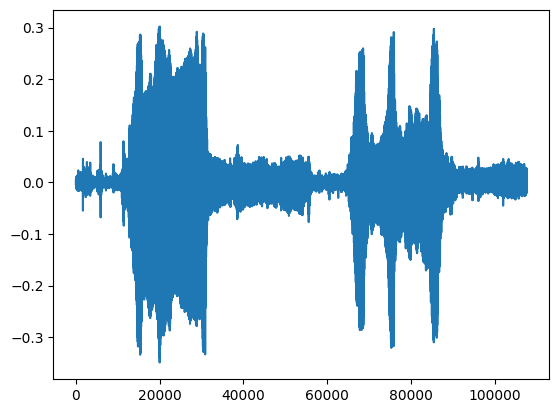

In [54]:
_ = plt.plot(wav_out)

In [55]:
# Utility functions for loading audio files and making sure the sample rate is correct.

# @tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
#     wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    wav = librosa.resample( np.array(wav), orig_sr=sample_rate, target_sr=16000)
    return wav

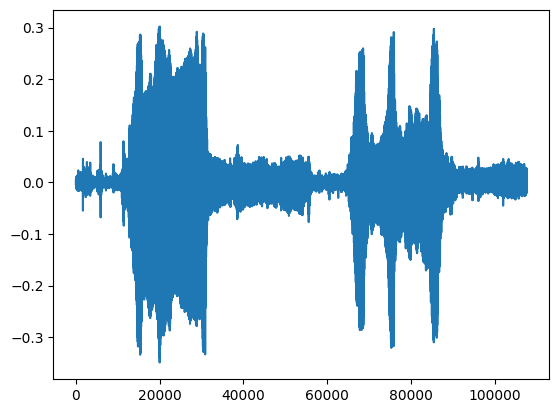

In [56]:
testing_wav_data = load_wav_16k_mono(testing_wav_file_name)

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data, rate=16000)

In [57]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
  print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
...


Run inference
YAMNet provides frame-level class-scores (i.e., 521 scores for every frame). In order to determine clip-level predictions, the scores can be aggregated per-class across frames (e.g., using mean or max aggregation). This is done below by scores_np.mean(axis=0). Finally, to find the top-scored class at the clip-level, you take the maximum of the 521 aggregated scores.

In [58]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Animal
The embeddings shape: (13, 1024)


ESC-50 dataset
The ESC-50 dataset (Piczak, 2015) is a labeled collection of 2,000 five-second long environmental audio recordings. The dataset consists of 50 classes, with 40 examples per class

In [59]:
_ = tf.keras.utils.get_file('esc-50.zip',
                        'https://github.com/karoldvl/ESC-50/archive/master.zip',
                        cache_dir='./',
                        cache_subdir=os.getcwd(),
                        extract=True)

645677056/Unknown 83s 0us/step

Explore the data
The metadata for each file is specified in the csv file at ./datasets/ESC-50-master/meta/esc50.csv

and all the audio files are in ./datasets/ESC-50-master/audio/

You will create a pandas DataFrame with the mapping and use that to have a clearer view of the data.

In [61]:
esc50_csv = 'ESC-50_extracted/ESC-50-master/meta/esc50.csv'
base_data_path = 'ESC-50_extracted/ESC-50-master/audio/'

pd_data = pd.read_csv(esc50_csv)
pd_data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


Filter the data
Now that the data is stored in the DataFrame, apply some transformations:

Filter out rows and use only the selected classes - dog and cat. If you want to use any other classes, this is where you can choose them.
Amend the filename to have the full path. This will make loading easier later.
Change targets to be within a specific range. In this example, dog will remain at 0, but cat will become 1 instead of its original value of 5.

In [62]:
my_classes = ['dog', 'cat']
map_class_to_id = {'dog':0, 'cat':1}


In [63]:
filtered_pd = pd_data[pd_data.category.isin(my_classes)]

In [64]:
filtered_pd

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
14,1-110389-A-0.wav,1,0,dog,True,110389,A
157,1-30226-A-0.wav,1,0,dog,True,30226,A
158,1-30344-A-0.wav,1,0,dog,True,30344,A
170,1-32318-A-0.wav,1,0,dog,True,32318,A
...,...,...,...,...,...,...,...
1832,5-217158-A-0.wav,5,0,dog,True,217158,A
1871,5-231762-A-0.wav,5,0,dog,True,231762,A
1968,5-256452-A-5.wav,5,5,cat,False,256452,A
1973,5-259169-A-5.wav,5,5,cat,False,259169,A


In [66]:
class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
class_id

0       0
14      0
157     0
158     0
170     0
       ..
1832    0
1871    0
1968    1
1973    1
1999    0
Name: category, Length: 80, dtype: int64

In [ ]:
filtered_pd = filtered_pd.assign(target=class_id) # target for cat 5 converted to 1

In [69]:
filtered_pd

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
14,1-110389-A-0.wav,1,0,dog,True,110389,A
157,1-30226-A-0.wav,1,0,dog,True,30226,A
158,1-30344-A-0.wav,1,0,dog,True,30344,A
170,1-32318-A-0.wav,1,0,dog,True,32318,A
...,...,...,...,...,...,...,...
1832,5-217158-A-0.wav,5,0,dog,True,217158,A
1871,5-231762-A-0.wav,5,0,dog,True,231762,A
1968,5-256452-A-5.wav,5,1,cat,False,256452,A
1973,5-259169-A-5.wav,5,1,cat,False,259169,A


In [70]:
full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))

In [71]:
full_path.head()

0      ESC-50_extracted/ESC-50-master/audio/1-100032-...
14     ESC-50_extracted/ESC-50-master/audio/1-110389-...
157    ESC-50_extracted/ESC-50-master/audio/1-30226-A...
158    ESC-50_extracted/ESC-50-master/audio/1-30344-A...
170    ESC-50_extracted/ESC-50-master/audio/1-32318-A...
Name: filename, dtype: object

In [72]:
filtered_pd = filtered_pd.assign(filename=full_path)
filtered_pd.head(10)

,filename,fold,target,category,esc10,src_file,take
0,ESC-50_extracted/ESC-50-master/audio/1-100032-...,1,0,dog,True,100032,A
14,ESC-50_extracted/ESC-50-master/audio/1-110389-...,1,0,dog,True,110389,A
157,ESC-50_extracted/ESC-50-master/audio/1-30226-A...,1,0,dog,True,30226,A
158,ESC-50_extracted/ESC-50-master/audio/1-30344-A...,1,0,dog,True,30344,A
170,ESC-50_extracted/ESC-50-master/audio/1-32318-A...,1,0,dog,True,32318,A
175,ESC-50_extracted/ESC-50-master/audio/1-34094-A...,1,1,cat,False,34094,A
176,ESC-50_extracted/ESC-50-master/audio/1-34094-B...,1,1,cat,False,34094,B
229,ESC-50_extracted/ESC-50-master/audio/1-47819-A...,1,1,cat,False,47819,A
230,ESC-50_extracted/ESC-50-master/audio/1-47819-B...,1,1,cat,False,47819,B
231,ESC-50_extracted/ESC-50-master/audio/1-47819-C...,1,1,cat,False,47819,C


Load the audio files and retrieve embeddings
Here you'll apply the load_wav_16k_mono and prepare the WAV data for the model.

When extracting embeddings from the WAV data, you get an array of shape (N, 1024) where N is the number of frames that YAMNet found (one for every 0.48 seconds of audio).

Your model will use each frame as one input. Therefore, you need to create a new column that has one frame per row. You also need to expand the labels and the fold column to proper reflect these new rows.

The expanded fold column keeps the original values. You cannot mix frames because, when performing the splits, you might end up having parts of the same audio on different splits, which would make your validation and test steps less effective.

In [73]:
filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

In [74]:

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
# Utility functions for loading audio files and making sure the sample rate is correct.

import numpy as np

def load_wav_16k_mono2(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    # numpy_array = tf.numpy_function(lambda x: np.array(x), [wav], tf.float32)
    # Convert the tensor to a NumPy array
    @tf.function(input_signature=[tf.TensorSpec(shape=[3], dtype=tf.int32)])
    def convert_to_numpy(wav):
        numpy_array = tf.make_ndarray(wav)
        return numpy_array
    # numpy_array = tf.eval(wav)
    @tf.function(input_signature=[tf.TensorSpec(shape=[3], dtype=tf.string)])
    def process_tensor(sample_rate):
        sample_rate = tf.cast(sample_rate, dtype=tf.int64)
        return  sample_rate
    
    numpy_array = convert_to_numpy(wav)
    sample_rate = process_tensor(sample_rate)

    
#     wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    wav = librosa.resample( numpy_array, orig_sr=sample_rate, target_sr=16000)
    return wav

In [127]:
@tf.function(input_signature=[tf.TensorSpec(shape=(None,), dtype=tf.float32)])
def load_wav_16k_mono_wav(wav):
    wav = tf.make_ndarray(wav)
    sample_rate = 16000
    wav_16k = tf.numpy_function(librosa.resample, [wav, sample_rate, 16000], tf.float32)
    return wav_16k

In [128]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono3(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = load_wav_16k_mono_wav(wav)
    return wav

In [129]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono3(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

AttributeError: in user code:

    File "C:\Users\lenovo\AppData\Local\Temp\ipykernel_11592\1190738288.py", line 2, in load_wav_for_map  *
        return load_wav_16k_mono3(filename), label, fold
    File "C:\Users\lenovo\AppData\Local\Temp\ipykernel_11592\749244595.py", line 12, in load_wav_16k_mono3  *
        wav = load_wav_16k_mono_wav(wav)
    File "C:\Users\lenovo\AppData\Local\Temp\ipykernel_11592\3608604687.py", line 3, in load_wav_16k_mono_wav  *
        wav = tf.make_ndarray(wav)

    AttributeError: 'SymbolicTensor' object has no attribute 'tensor_shape'


In [ ]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

In [ ]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()

In [ ]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [ ]:
history = my_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback)

In [ ]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

In [ ]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
result = my_model(embeddings).numpy()

inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')

In [ ]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)

In [ ]:
saved_model_path = './dogs_and_cats_yamnet'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
reloaded_results = reloaded_model(testing_wav_data)
cat_or_dog = my_classes[tf.math.argmax(reloaded_results)]
print(f'The main sound is: {cat_or_dog}')

In [ ]:
serving_results = reloaded_model.signatures['serving_default'](testing_wav_data)
cat_or_dog = my_classes[tf.math.argmax(serving_results['classifier'])]
print(f'The main sound is: {cat_or_dog}')